# Libraries

In [1]:
# tensorflow utils
import tensorflow as tf

# matplotlib utils
import matplotlib as mpl
import matplotlib.pyplot as plt

# other utils
import numpy as np
import pandas as pd
import seaborn as sn

# Datasets

In [2]:
( (p_images, p_labels),
  (q_images, q_labels), ) = tf.keras.datasets.mnist.load_data()

# normalize
p_images = p_images / 255.0
q_images = q_images / 255.0

# Noises

In [3]:
class CauchyNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, amplify: float, clip=(0, 1)):
        super(CauchyNoiseLayer, self).__init__()
        self.clip = clip
        self.amplify = amplify

    def call(self, inputs, training=None):
        r1 = tf.random.normal(shape=tf.shape(inputs), mean=0, stddev=1)
        r2 = tf.random.normal(shape=tf.shape(inputs), mean=0, stddev=1)
        return tf.clip_by_value(inputs + self.amplify*(r1 / r2), self.clip[0], self.clip[1])

class NormalNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, mean: float, stddev: float, clip=(0, 1)):
        super(NormalNoiseLayer, self).__init__()
        self.clip = clip
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=None):
        noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
        return tf.clip_by_value(inputs + noise, self.clip[0], self.clip[1])

class UniformNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, minval: float, maxval: float, clip=(0, 1)):
        super(UniformNoiseLayer, self).__init__()
        self.clip = clip
        self.minval = minval
        self.maxval = maxval
        
    def call(self, inputs, training=None):
        noise = tf.random.uniform(shape=tf.shape(inputs), minval=self.minval, maxval=self.maxval)
        return tf.clip_by_value(inputs + noise, self.clip[0], self.clip[1])

# Model

In [4]:
model = tf.keras.models.load_model('../models/model.mnist.keras')

# Test :: without noise

In [5]:
# evaluation
p_eval = model.evaluate(p_images, p_labels)
q_eval = model.evaluate(q_images, q_labels)

# prediction
p_pred = model.predict(p_images).argmax(-1)
q_pred = model.predict(q_images).argmax(-1)

# confusion
p_conf = tf.math.confusion_matrix(p_labels, p_pred)
q_conf = tf.math.confusion_matrix(q_labels, q_pred)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - accuracy: 0.9860 - loss: 0.0442
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.9703 - loss: 0.0953
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step


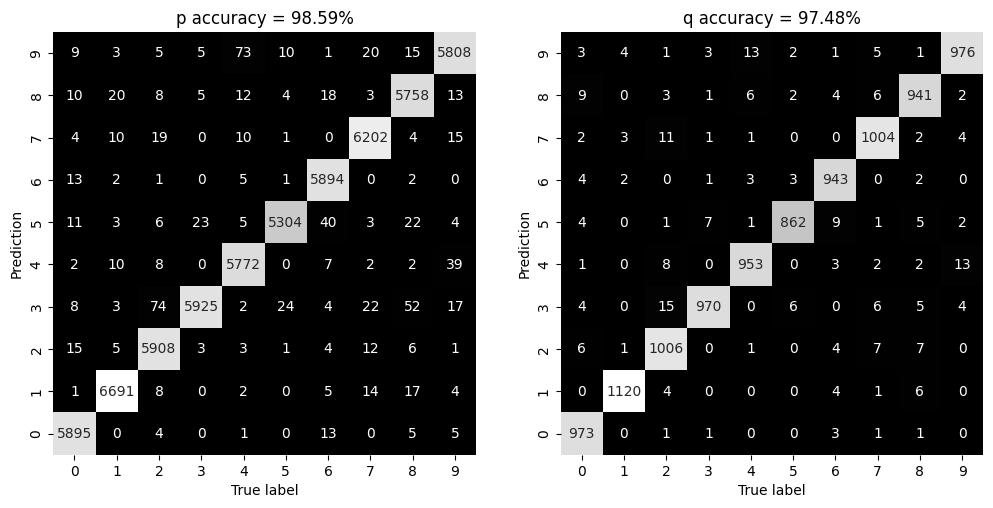

In [6]:
plt.figure(figsize=(12, 8))

# visualize p confusion matrix
plt.subplot(1, 2, 1)
sn.heatmap(pd.DataFrame(p_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
plt.title(f'p accuracy = {p_eval[1]:.2%}')
plt.xlabel('True label')
plt.ylabel('Prediction')

# visualize q confusion matrix
plt.subplot(1, 2, 2)
sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
plt.title(f'q accuracy = {q_eval[1]:.2%}')
plt.xlabel('True label')
plt.ylabel('Prediction')

plt.show()

# Test :: with Cauchy noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.9703 - loss: nan  
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


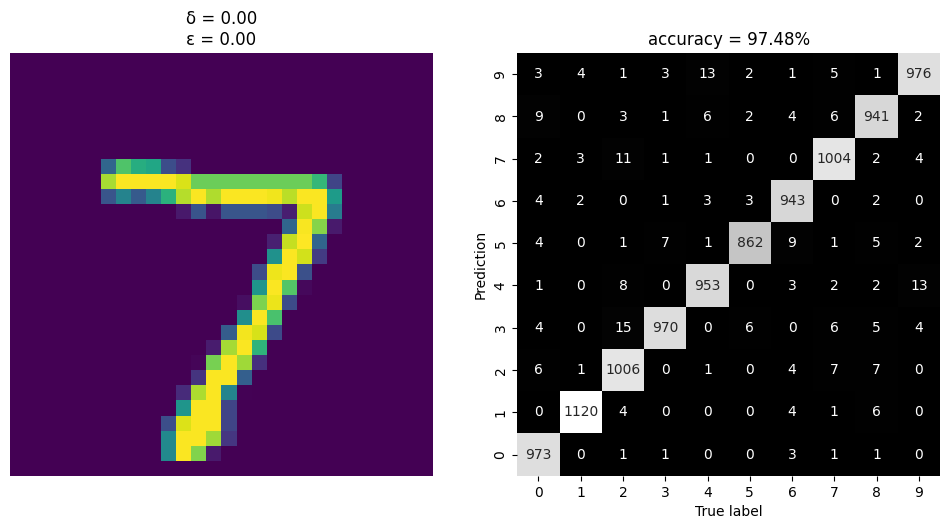

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.9711 - loss: 0.0992
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


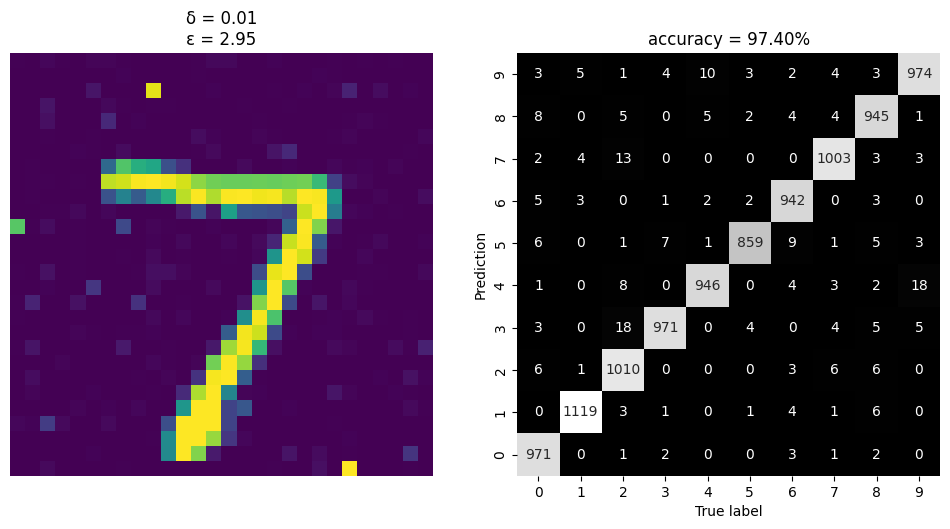

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.9678 - loss: 0.1077
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


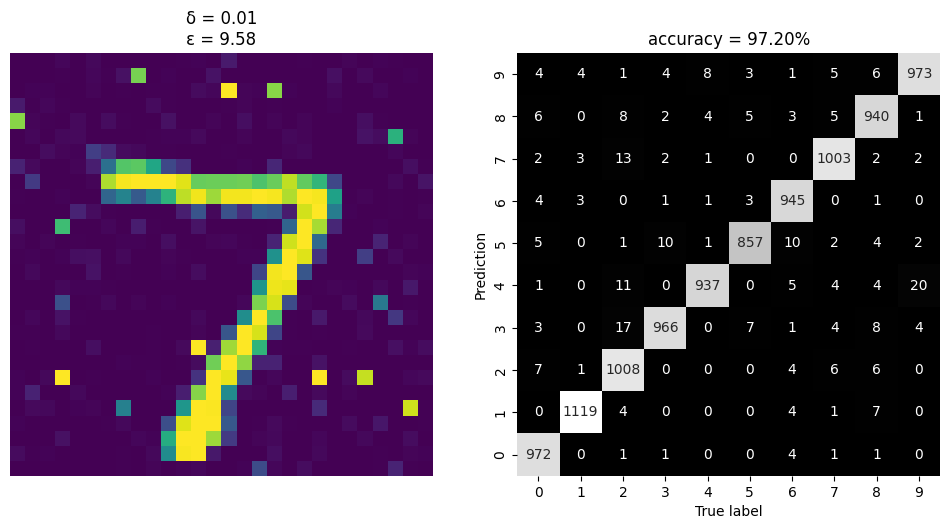

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.9620 - loss: 0.1249
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step


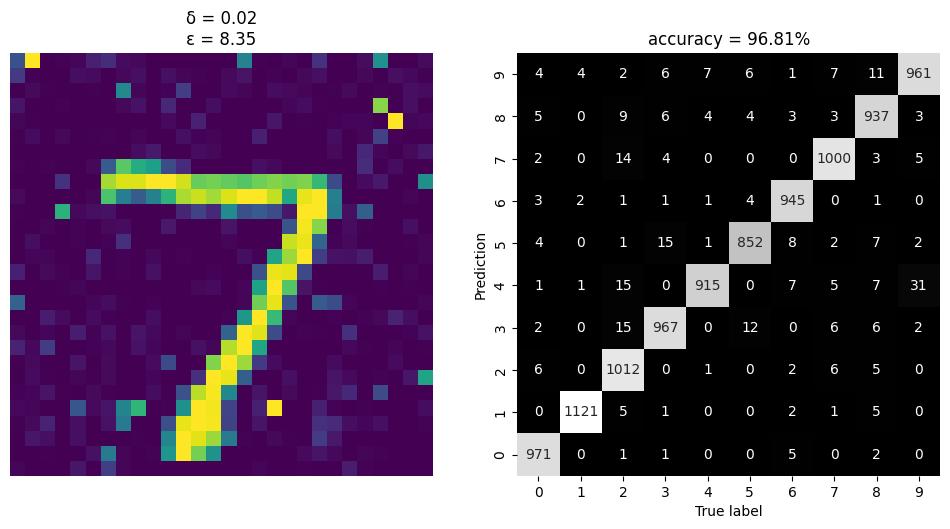

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.9199 - loss: 0.2671
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step


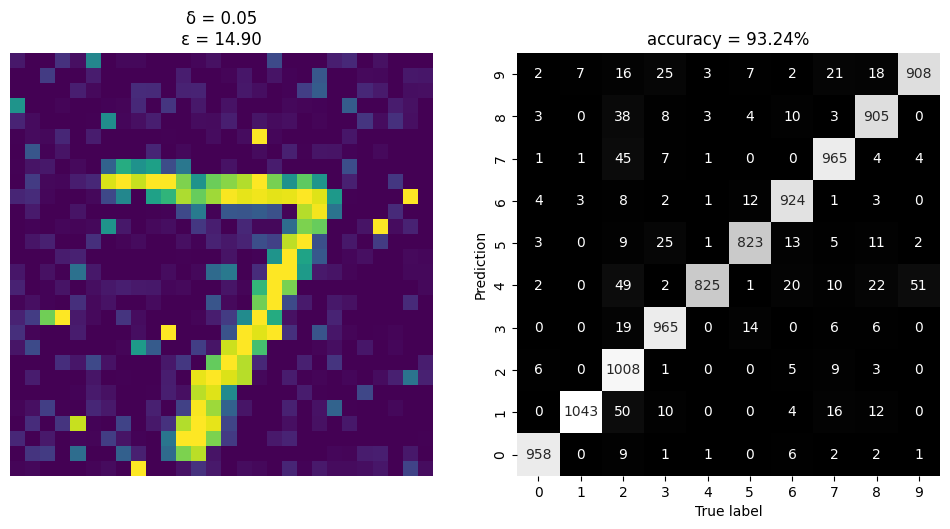

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7662 - loss: 0.7489
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


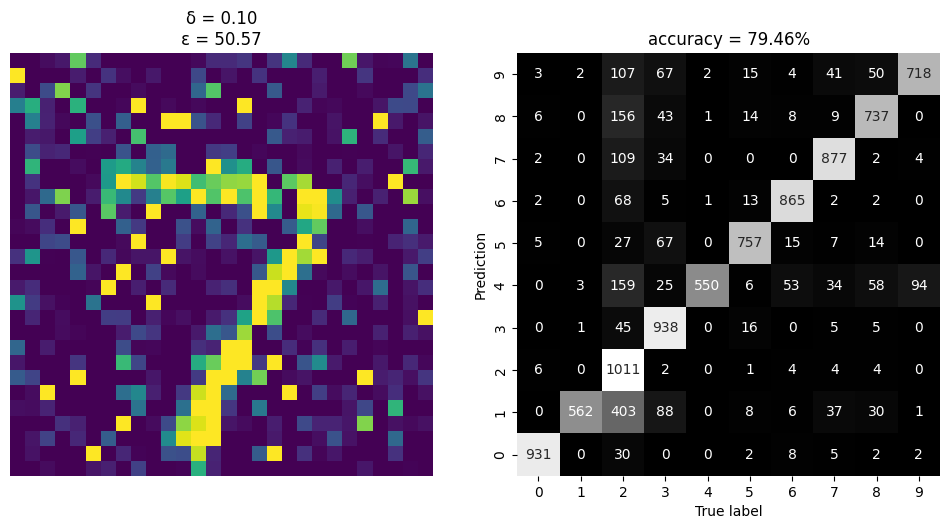

In [13]:
for noise_level in (0, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1):
    q_noised = CauchyNoiseLayer(amplify=noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'δ = {noise_level:.2f}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():.2f}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()

# Test :: with Normal noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.9703 - loss: 0.0953
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


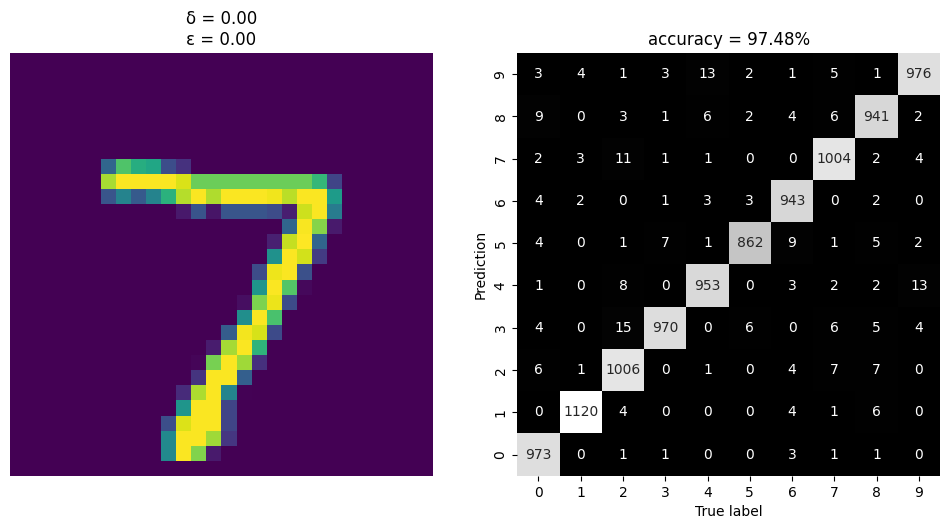

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.9643 - loss: 0.1222
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


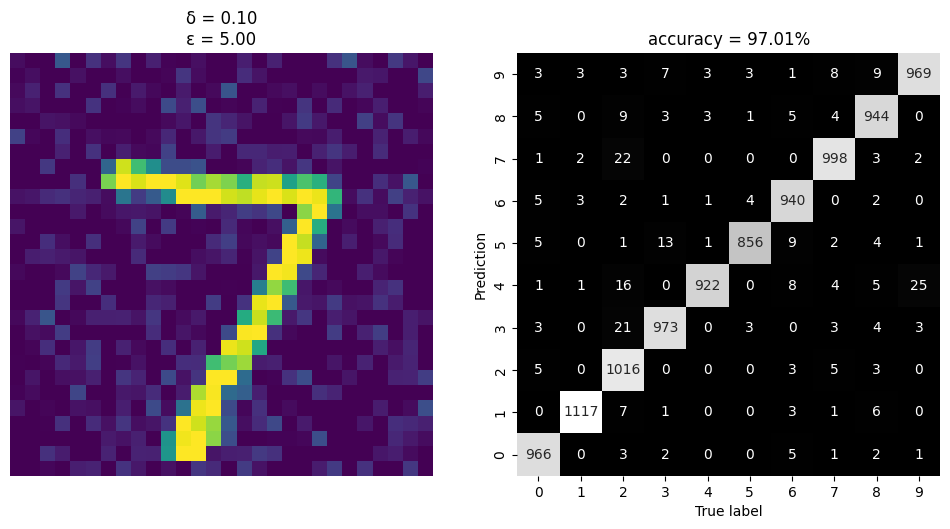

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.9488 - loss: 0.1756
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


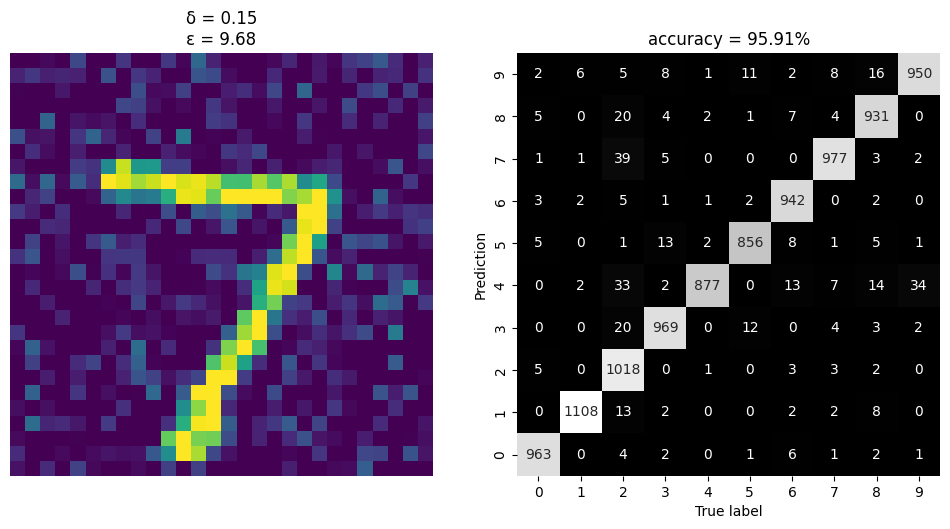

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.9081 - loss: 0.2942
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


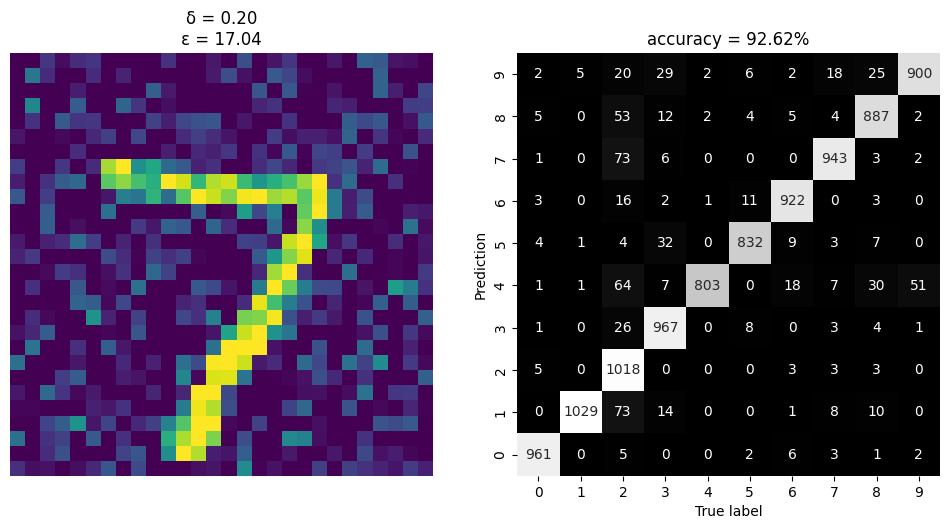

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.8269 - loss: 0.5139
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step


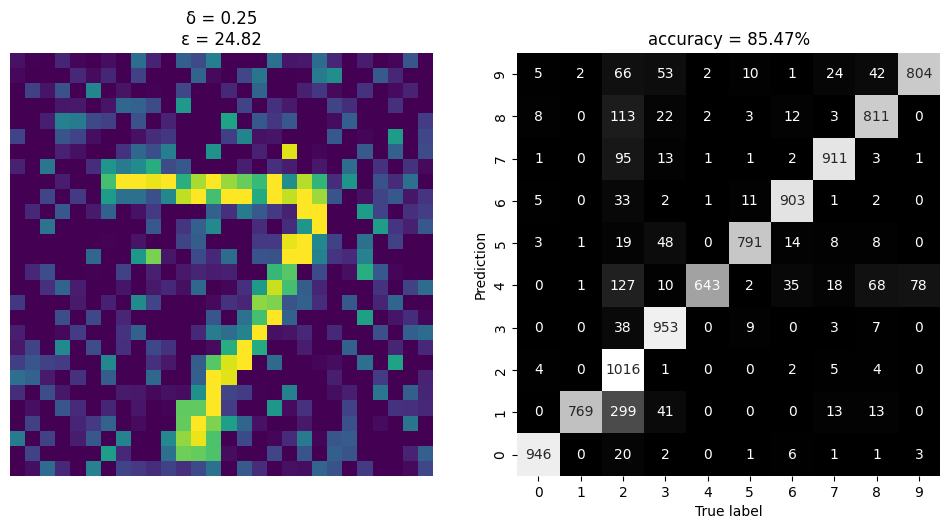

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.7416 - loss: 0.8541
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step


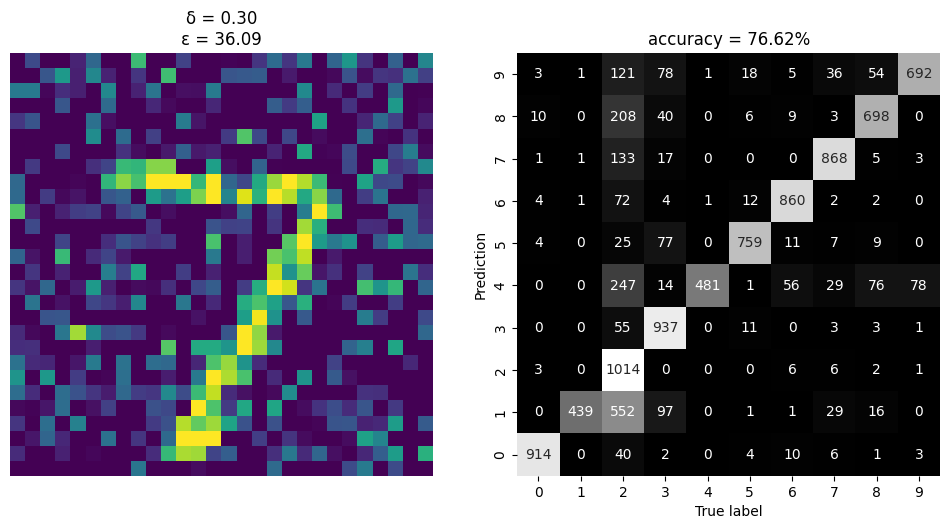

In [10]:
for noise_level in (0, 1e-1, 1.5e-1, 2e-1, 2.5e-1, 3e-1):
    q_noised = NormalNoiseLayer(mean=0, stddev=noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'δ = {noise_level:.2f}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():.2f}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()

# Test :: with Uniform noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.9703 - loss: 0.0953
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


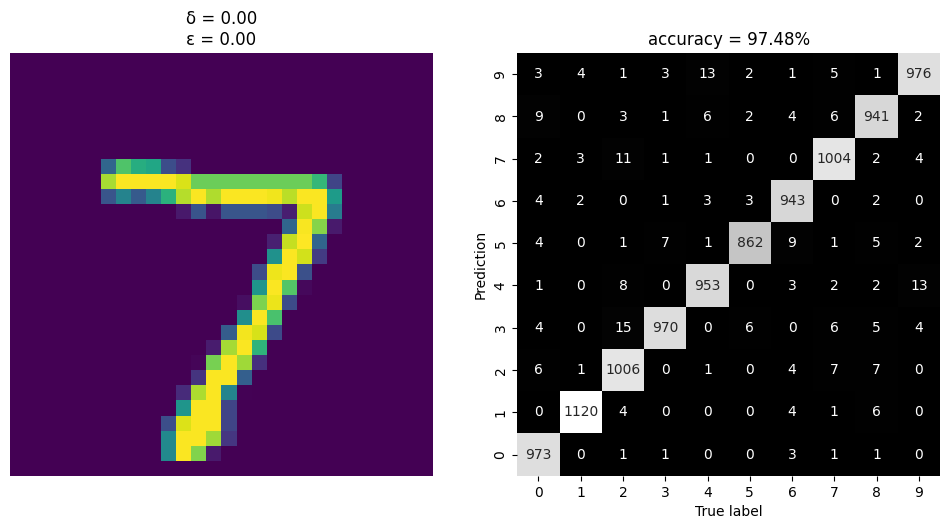

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.9682 - loss: 0.1042
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


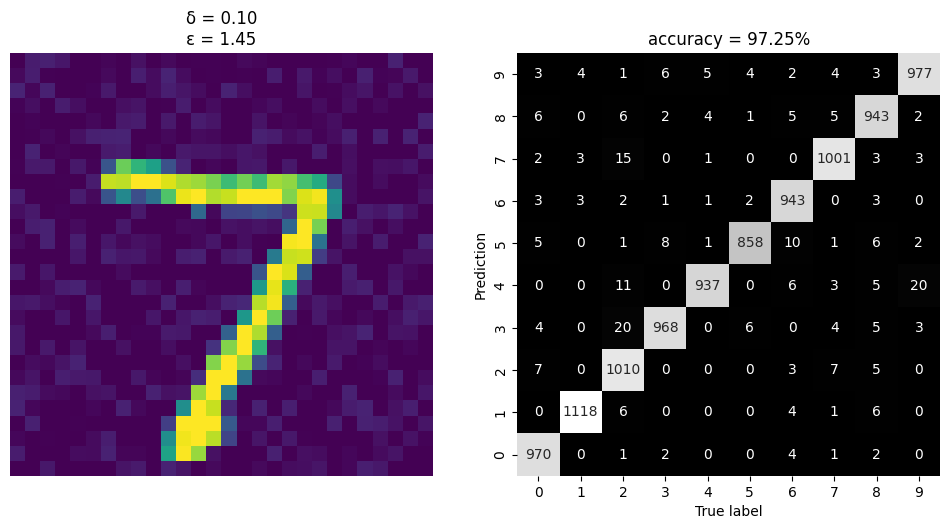

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.9600 - loss: 0.1376
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step


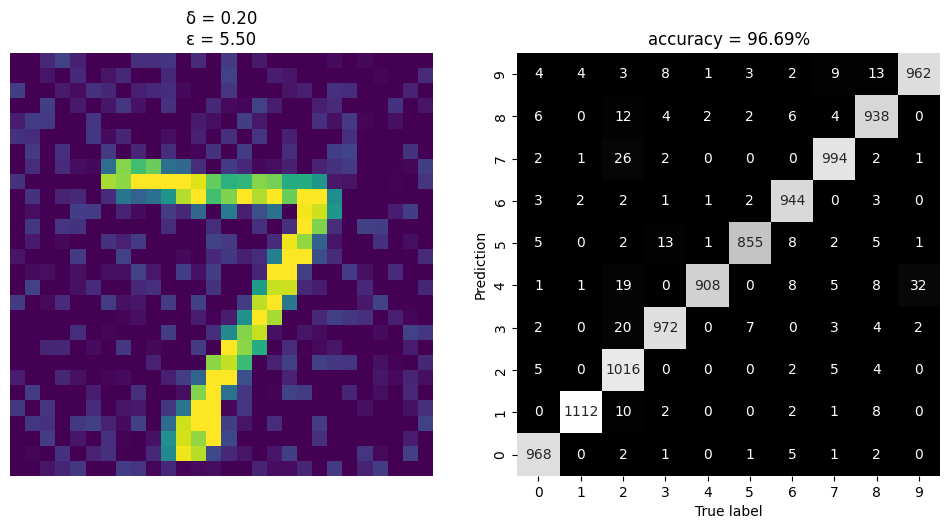

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.9271 - loss: 0.2372
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step


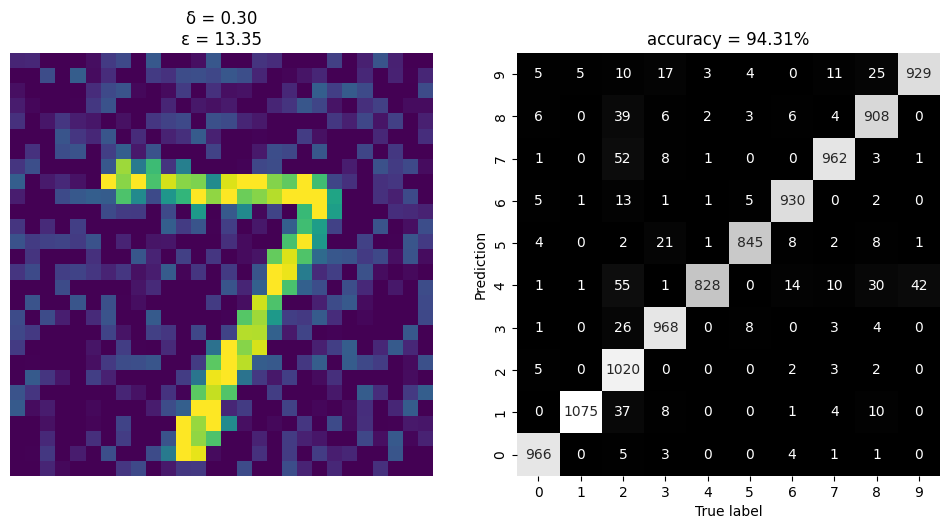

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.8411 - loss: 0.4869
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


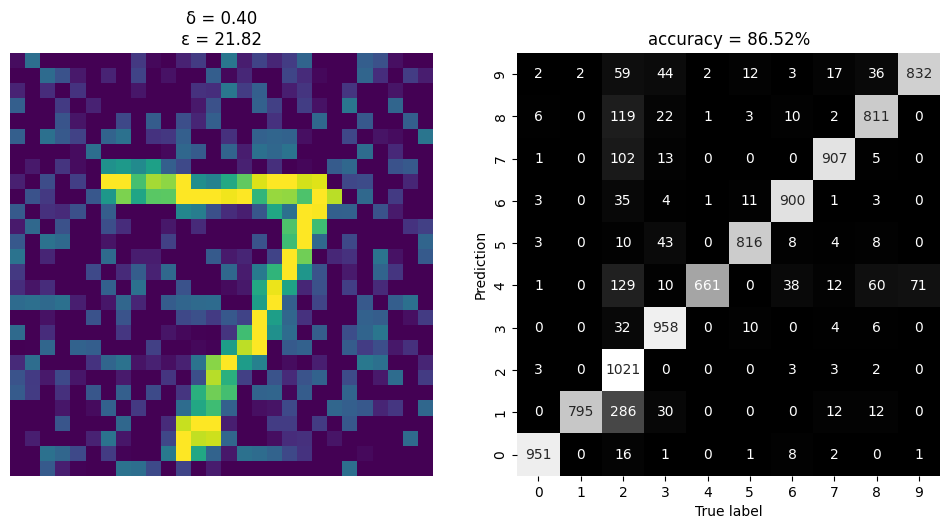

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.7158 - loss: 0.9340
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step


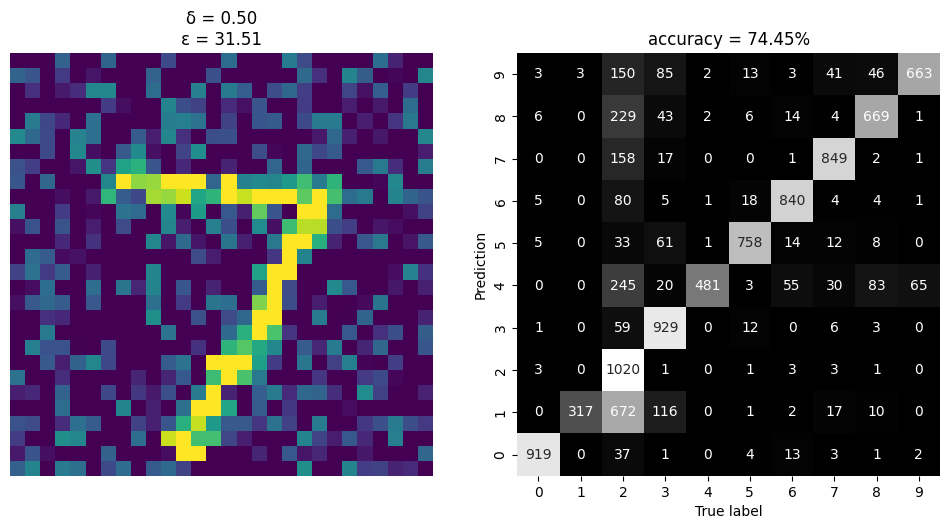

In [12]:
for noise_level in (0, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1):
    q_noised = UniformNoiseLayer(minval=-noise_level, maxval=+noise_level)(q_images)

    # evaluation
    q_eval = model.evaluate(q_noised, q_labels)

    # prediction
    q_pred = model.predict(q_noised).argmax(-1)

    # confusion
    q_conf = tf.math.confusion_matrix(q_labels, q_pred)

    plt.figure(figsize=(12, 8))

    # visualize noised digit
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title(f'δ = {noise_level:.2f}\nε = {((q_images[0] - q_noised[0]) ** 2).numpy().sum():.2f}')
    plt.imshow(q_noised[0])

    # visualize confusion matrix
    plt.subplot(1, 2, 2)
    sn.heatmap(pd.DataFrame(q_conf), annot=True, cbar=False, cmap='gist_gray', fmt='g', square=True).invert_yaxis()
    plt.title(f'accuracy = {q_eval[1]:.2%}')
    plt.xlabel('True label')
    plt.ylabel('Prediction')

    plt.show()